# Outcome Analysis

## Housekeeping

In [21]:
# If in colab, mount drive and set wd
# If local, set wd to parent of notebook
import os
import re

try:
  from google.colab import drive
  drive.mount('/content/drive')
  os.chdir('/content/drive/MyDrive/ds1_nhanes/')
except:
  from pathlib import Path
  if not re.search(r'ds1_nhanes$', str(os.getcwd())):
    os.chdir(Path(os.getcwd()).parent)

print(os.getcwd())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/ds1_nhanes


Packages needed for this notebook:

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# Random forest things
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay

# Trad stat things
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
!pip install scikit_posthocs
import scikit_posthocs as sp

Loading dataset with cluster assignments (temporary at the time of writing):

In [23]:
df = pd.read_csv('data/clean/nhanes_2017_2023_clustered.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19386 entries, 0 to 19385
Data columns (total 54 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   SEQN                       19386 non-null  int64  
 1   weight_2d                  19386 non-null  float64
 2   grams                      19386 non-null  float64
 3   f_total_(cup_eq)           19386 non-null  float64
 4   f_citmlb_(cup_eq)          19386 non-null  float64
 5   f_other_(cup_eq)           19386 non-null  float64
 6   f_juice_(cup_eq)           19386 non-null  float64
 7   v_total_(cup_eq)           19386 non-null  float64
 8   v_drkgr_(cup_eq)           19386 non-null  float64
 9   v_redor_total_(cup_eq)     19386 non-null  float64
 10  v_redor_tomato_(cup_eq)    19386 non-null  float64
 11  v_redor_other_(cup_eq)     19386 non-null  float64
 12  v_starchy_total_(cup_eq)   19386 non-null  float64
 13  v_starchy_potato_(cup_eq)  19386 non-null  flo

Check group counts:

In [24]:
df['cluster'].value_counts()

,count
cluster,
2,12145
1,3934
3,2640
0,667


Keep in mind that this is pretty uneven. Will affect some analyses.

## Demographics

### ANOVAS and Chi2

Start with categorical variables and Chi2:

In [33]:
cat_results = []

for demo in ['gender', 'race', 'education']:
  contingency = pd.crosstab(df[demo], df['cluster'])
  chi2, p, dof, expected = stats.chi2_contingency(contingency)
  cat_results.append([demo, '{:.3f}'.format(chi2), '{:.3f}'.format(p), dof])

# Put together in df
cat_results = pd.DataFrame(cat_results, columns=['Demo', 'Value', 'p', 'DoF'])

# Add stat identifier, format chi2 for latex
cat_results['Stat'] = '\(\chi^2\)'
cat_results = cat_results[['Demo', 'Stat', 'Value', 'DoF', 'p']]

# Format Demo column
cat_results['Demo'] = cat_results['Demo'].str.title()

cat_results


,Demo,Stat,Value,DoF,p
0,Gender,\(\chi^2\),92.159,3,0.000
1,Race,\(\chi^2\),595.401,12,0.000
2,Education,\(\chi^2\),1763.023,15,0.000


ANOVA with numeric variables:

In [51]:
num_results = []

for demo in ['age', 'income_ratio']:
  lm = smf.ols(
    f'{demo} ~ cluster',
    data=df
  ).fit()
  num_results.append(sm.stats.anova_lm(lm))

# Put into a data frame
num_df = pd.concat(num_results, axis=0)

# Drop residual rows
num_df = num_df[~num_df['PR(>F)'].isna()]

# Add demo column
num_df['Demo'] = ['Age', 'Income Ratio']

# Add test identifier
num_df['Stat'] = 'F'

# Reorder
num_df = num_df[['Demo', 'Stat', 'F', 'df', 'PR(>F)']].reset_index(drop=True)

# Format column names
num_df.columns = ['Demo', 'Stat', 'Value', 'DoF', 'p']

# Reformat, add F to distinguish from Chi2
num_df['DoF'] = num_df['DoF'].astype(int)
num_df['Value'] = num_df['Value'].apply(lambda x: '{:.3f}'.format(x))
num_df['p'] = num_df['p'].apply(lambda x: '{:.3f}'.format(x))

num_df

,Demo,Stat,Value,DoF,p
0,Age,F,16.290,1,0.000
1,Income Ratio,F,0.043,1,0.835


In [35]:
# Try posthoc test for ANOVA
age_ph = sp.posthoc_ttest(
    df,
    val_col='age',
    group_col='cluster',
    p_adjust='holm'
)

# Formatting
age_ph = age_ph.map(lambda x: '{:.3f}'.format(x))
print(f'Age:\n{age_ph}\n')

# For income
inc_ph = sp.posthoc_ttest(
    df,
    val_col='income_ratio',
    group_col='cluster',
    p_adjust='holm'
)

# Formatting
inc_ph = inc_ph.map(lambda x: '{:.3f}'.format(x))
print(f'Income:\n{inc_ph}\n')

Age:
       2      1      3      0
2  1.000  0.000  0.000  0.000
1  0.000  1.000  0.000  0.000
3  0.000  0.000  1.000  0.019
0  0.000  0.000  0.019  1.000

Income:
       2      1      3      0
2  1.000  0.000  0.000  0.000
1  0.000  1.000  0.000  0.000
3  0.000  0.000  1.000  0.180
0  0.000  0.000  0.180  1.000



Combine into one table and export to latex:

In [36]:
demo_table = pd.concat([cat_results, num_df], axis=0)
print(demo_table)
demo_table.to_latex(
    'outputs/checkin_3/analysis_demos.tex',
    index=False,
    label='tab:cluster_demo_tests',
    position='h',
    caption='Tests for differences in demographics among clusters'
)

           Demo        Stat     Value  DoF      p
0        Gender  \(\chi^2\)    92.159    3  0.000
1          Race  \(\chi^2\)   595.401   12  0.000
2     Education  \(\chi^2\)  1763.023   15  0.000
0           Age           F    16.290    1  0.000
1  Income Ratio           F     0.043    1  0.835


This is pretty hinky - it was showing all significant earlier, but now income ratio is far from it. I suppose it was a slightly different cluster outcome, but I'm skeptical it would have had such a huge swing. The F stat was like 10 before. Will have to poke around here.

### Graphs

In [37]:
weighted_demos = df.groupby(['cluster', 'race'], observed=True)['weight_2d'].sum().unstack(fill_value=0)
percent_demos = weighted_demos.div(weighted_demos.sum(axis=1), axis=0) * 100
print(percent_demos.round(1))

race     Black  Mexican American  Other Hispanic  Other or Multi  White
cluster                                                                
0         14.4               5.4             6.8             7.5   65.9
1          7.0               6.3             6.7             9.2   70.8
2         14.5              11.2            11.4            12.1   50.7
3          8.7               9.0             6.8            11.5   64.0


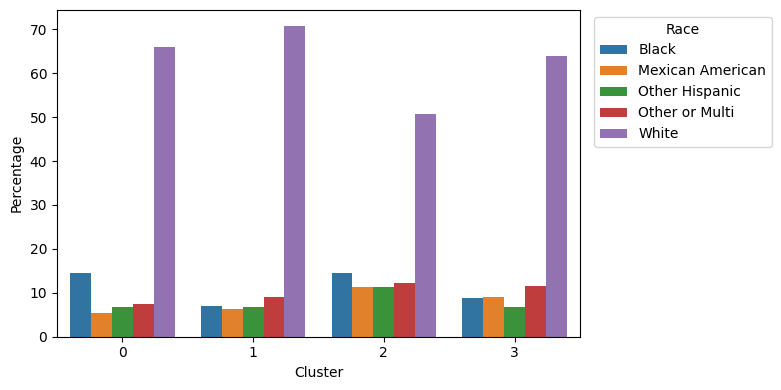

In [38]:
demos_long = percent_demos.reset_index().melt(
    id_vars='cluster',
    var_name='race',
    value_name='weight'
)
plt.figure(figsize=(6, 4))
ax = sns.barplot(
    data=demos_long,
    x='cluster',
    y='weight',
    hue='race'
)
ax.set(
  ylabel = 'Percentage',
  xlabel = 'Cluster'
)
ax.legend(title='Race')
plt.tight_layout()
sns.move_legend(ax, 'upper right', bbox_to_anchor=(1.38, 1))

plt.savefig('outputs/checkin_3/demos_race_clusters.png')
plt.show()


Income:

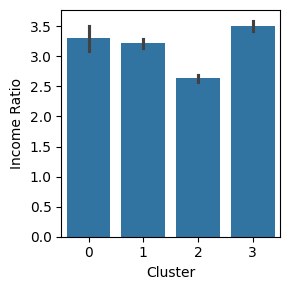

In [39]:
plt.figure(figsize=(3, 3))
ax = sns.barplot(
    data=df,
    x='cluster',
    y='income_ratio',
    weights='weight_2d'
)
ax.set(
  ylabel = 'Income Ratio',
  xlabel = 'Cluster'
)
plt.tight_layout()

plt.savefig('outputs/checkin_3/demos_income_clusters.png')
plt.show()

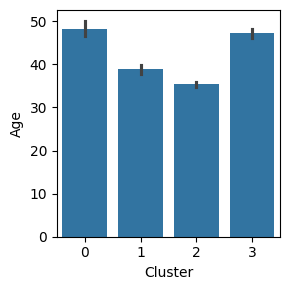

In [40]:
plt.figure(figsize=(3, 3))
ax = sns.barplot(
    data=df,
    x='cluster',
    y='age',
    weights='weight_2d'
)
ax.set(
  ylabel = 'Age',
  xlabel = 'Cluster'
)
plt.tight_layout()

plt.savefig('outputs/checkin_3/demos_age_clusters.png')
plt.show()


### Random Forest

Train test split workflow to see how well demographics predict cluster assignments. This isn't really a thing, and isn't really part of our research questions. But it's sorta neat

In [41]:
# Get df of demos and cluster only, set as X and y
dat = df[['cluster', 'age', 'education', 'income_ratio', 'gender', 'race']]
X = dat.drop(columns=['cluster'])
y = dat['cluster']

# Define variable types for preprocessing
cat_vars = ['education', 'gender', 'race']
num_vars = ['age', 'income_ratio']

# Split dataset, stratify by clusters to account for uneven groups
X_train, X_test, y_train, y_test = train_test_split(
  X,
  y,
  test_size=0.2,
  random_state=42,
  stratify=y
)

# Preprocess, one hot encoding for categorical variables
preprocess = ColumnTransformer(
  transformers=[
    ('num', StandardScaler(), num_vars),
    ('cat', OneHotEncoder(drop='first'), cat_vars)
  ]
)

# Create model
clf = RandomForestClassifier(
  n_estimators=100,
  max_features='sqrt',
  random_state=42
)

# Create processing pipeline
pipe = Pipeline([
  ('prep', preprocess),
  ('clf', clf)
])

# Fit model and get predictions
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

#### Confusion Matrix

Accuracy: 55.80%


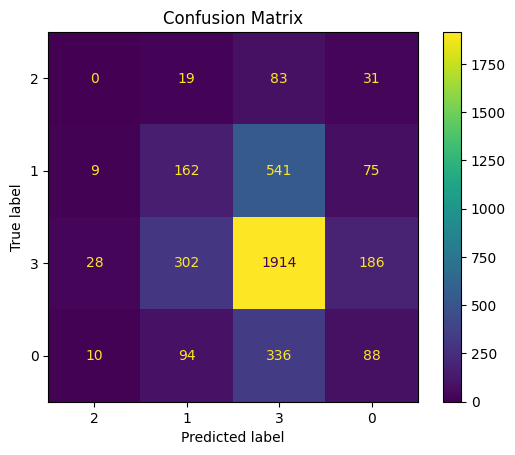

In [42]:
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

cm = confusion_matrix(y_test, y_pred)

display = ConfusionMatrixDisplay(
  confusion_matrix=cm,
  display_labels=df['cluster'].unique()
)
display.plot()
plt.title('Confusion Matrix')
plt.show()

Accuracy is 55%, which is perhaps not the worst thing ever because there are 4 groups. So it's better than random. And that's something, considering I wouldn't expect demographics to be THAT great of a predictor of these clusters.

Seemingly needlessly complicated way to get a normalized plot. Here is [source](https://www.geeksforgeeks.org/how-to-plot-confusion-matrix-with-labels-in-sklearn/).

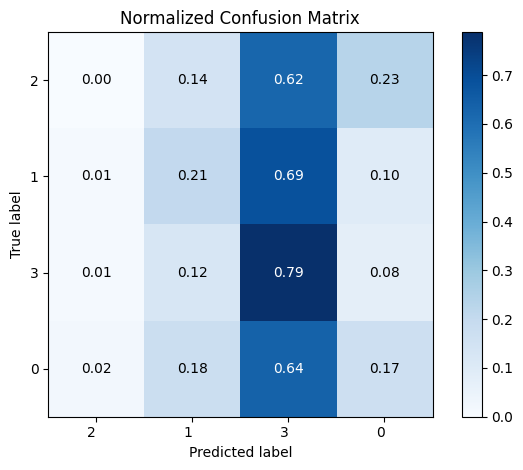

In [43]:
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots()
im = ax.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)

ax.set(
    xticks=np.arange(cm.shape[1]),
    yticks=np.arange(cm.shape[0]),
    xticklabels=df['cluster'].unique(),
    yticklabels=df['cluster'].unique(),
    title='Normalized Confusion Matrix',
    ylabel='True label',
    xlabel='Predicted label'
)

plt.setp(
    ax.get_xticklabels(),
    ha="right",
    rotation_mode="anchor"
)

fmt = '.2f'
thresh = cm_normalized.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm_normalized[i, j], fmt),
                ha="center", va="center",
                color="white" if cm_normalized[i, j] > thresh else "black")
fig.tight_layout()
plt.show()

#### Feature Importance

In [44]:
# Get feature names out of our pipe
feature_names = pipe.named_steps['prep'].get_feature_names_out()
print(feature_names)
print(len(feature_names))

# Pull out feature importances
importances = clf.feature_importances_

# Get indices for descending order of importances
indices = np.argsort(importances)

['num__age' 'num__income_ratio' 'cat__education_College graduate or above'
 "cat__education_Don't know" 'cat__education_High school/GED'
 'cat__education_Less than 9th grade' 'cat__education_Some college or AA'
 'cat__gender_Male' 'cat__race_Mexican American'
 'cat__race_Other Hispanic' 'cat__race_Other or Multi' 'cat__race_White']
12


Text(0, 0.5, 'Features')

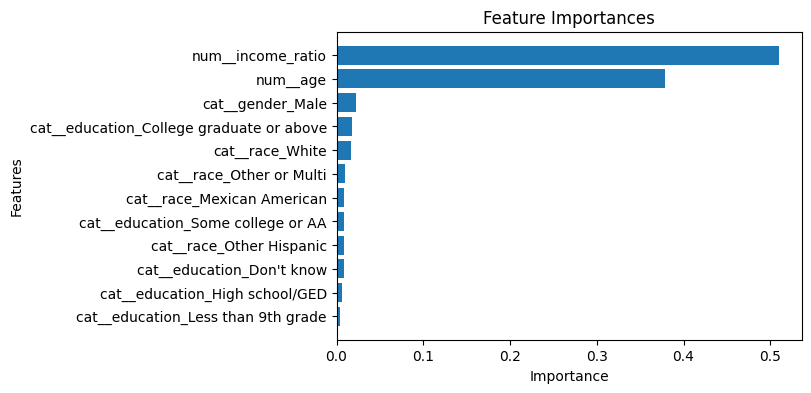

In [45]:
# Plot, arranging features in same order as indices
plt.figure(figsize=(6, 4))
plt.title("Feature Importances")
plt.barh(feature_names[indices], importances[indices])
plt.xlabel("Importance")
plt.ylabel("Features")


Don't much like how the one-hot encoding persists into here. Let's try adding together each of the importances for the categorical variables. Not entirely sure this is kosher but we're doing it.

In [46]:
# Get df of features and importances
imp_df = pd.DataFrame({'feature': feature_names, 'importance': importances})

# Combine importances for gender, education, race
for demo in ['gender', 'education', 'race']:
  out = imp_df.loc[imp_df['feature'].str.contains(demo), 'importance'].sum()
  imp_df.loc[len(imp_df)] = [demo, out]

# Drop rows that contain 'cat'
imp_df = imp_df[~imp_df['feature'].str.contains('^cat')]

# remove prefix num__
imp_df['feature'] = imp_df['feature'].str.replace('num__', '')

# Arrange by importance
imp_df = imp_df.sort_values(by='importance', ascending=False)

# Features in title case
imp_df['feature'] = imp_df['feature'].str.title().str.replace('_', ' ')
print(imp_df)

         feature  importance
1   Income Ratio    0.510532
0            Age    0.378716
13     Education    0.044449
14          Race    0.043359
12        Gender    0.022944


Text(0, 0.5, 'Features')

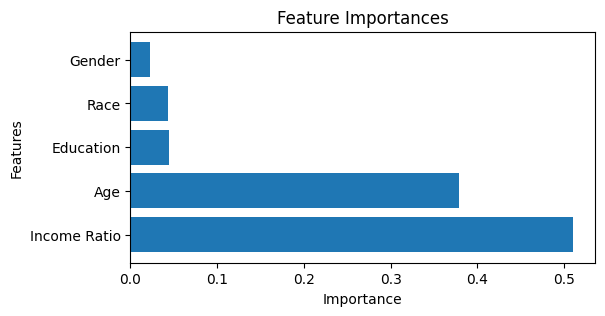

In [47]:
# Plot cleaner feature importance
plt.figure(figsize=(6, 3))
plt.title("Feature Importances")
plt.barh(imp_df['feature'], imp_df['importance'])
plt.xlabel("Importance")
plt.ylabel("Features")

Kinda neat. Probably not worth including. But kinda neat